In [7]:
library(data.table)
library(ggplot2)
library(Seurat)
library(dplyr)
library(stringr)

library(ggpubr)
library(biomaRt)
library(AUCell)
library(ComplexHeatmap)
library(monocle3)
library(circlize)
source("processing_functions.R")

Specify a folder below where all the downloaded data is to be stored

In [2]:
data_dir <- file.path( "data" )

# E9.5 trunk neural crest data 

In [ ]:
trunk_ncc_obj <- load_trunk_neural_crest()

# E12.5 and E13.5 SCP data

In [4]:
scp_obj <- load_sc_precursors()

# Myelinating and non-myelinating SC data

In [5]:
sc_obj <- load_sc_data()

# Merge together datasets

In [8]:
scp_trunk_obj <- merge( scp_obj, trunk_ncc_obj )

#Next, we merge the SCP + Trunk data with the SC data. development_obj contains all the merged
#data.
development_obj <- merge( scp_trunk_obj, sc_obj )

#Compute cell cycle scores for each cell. This is important, since embryonic cells tend to be 
#proliferative, and these cells are likely in different cell states. We want to remove the influence
#of cell cycle state on the trajectory.
development_obj <- CellCycleScoring( development_obj, s.features=mouse_s_genes,
                                   g2m.features=mouse_g2m_genes)

#Removing the intermediate merge object to save up some memory.
rm(scp_trunk_obj)


#The command below takes a while to run. This derives marker genes for each cluster while
#accounting for cell cycle state and the number of expressed genes as covariates.
markers_df <- FindAllMarkers( development_obj, latent.vars=c("S.Score","G2M.Score","nFeature_RNA"),
                         test.use="LR" )

All the development data (trunk neural crest, SCP) are SMART-seq, while mySC and nmSC data is 10X.
This means that any PCs used by Monocle3 for trajectory construction is confounded by library size differences. 

To reduce the effect of library size variation, we sub-sample reads from the development data to match the read
count distribution of the nmSC and mySC (non-myelinating and myelinating Schwann cells) cells.

In [9]:
source("processing_functions.R")
meta_data_dt <- data.table( development_obj@meta.data, keep.rownames=T ) %>%
                                                        setnames("rn","cell.name")


read_counts_to_subsample <- meta_data_dt[!cell.type %in% c("mySC","nmSC"),.(cell.name,nCount_RNA)] %>% tibble::deframe(.)
read_counts_reference <- meta_data_dt[cell.type %in% c("mySC","nmSC"),.(cell.name,nCount_RNA)] %>% tibble::deframe(.)

random.seed <- 1
set.seed(random.seed)
resampled_development_obj <- create_resampled_seurat_obj( development_obj[["RNA"]]@counts,
                                                         meta_data_dt,
                                                         read_counts_to_subsample,
                                                         read_counts_reference
                                                         )

#This object contains resampled SMART-seq cells. Note that the nFeature_RNA and nCount_RNA values
#in the resampled object do not reflect the actual gene and read counts of the resampled cells.
#This command will throw up a bunch of warnings from the glm.fit package. Ignore them.
resampled_development_obj <- AddMetaData( resampled_development_obj,
                                         resampled_development_obj@meta.data %>% dplyr::select(-cell.name))

# Compute trajectory

In [14]:
trajectory_cds_obj <- compute_pseudotime( resampled_development_obj )

Warning message:
“The following arguments are not used: nfeatures”
Aligning cells from different batches using Batchelor. 
Please remember to cite:
	 Haghverdi L, Lun ATL, Morgan MD, Marioni JC (2018). 'Batch effects in single-cell RNA-sequencing data are corrected by matching mutual nearest neighbors.' Nat. Biotechnol., 36(5), 421-427. doi: 10.1038/nbt.4091

Warning message:
“'pc.input=TRUE' and 'use.dimred=TRUE' are deprecated.
Use 'reducedMNN' instead.”


  |======================================================================| 100%


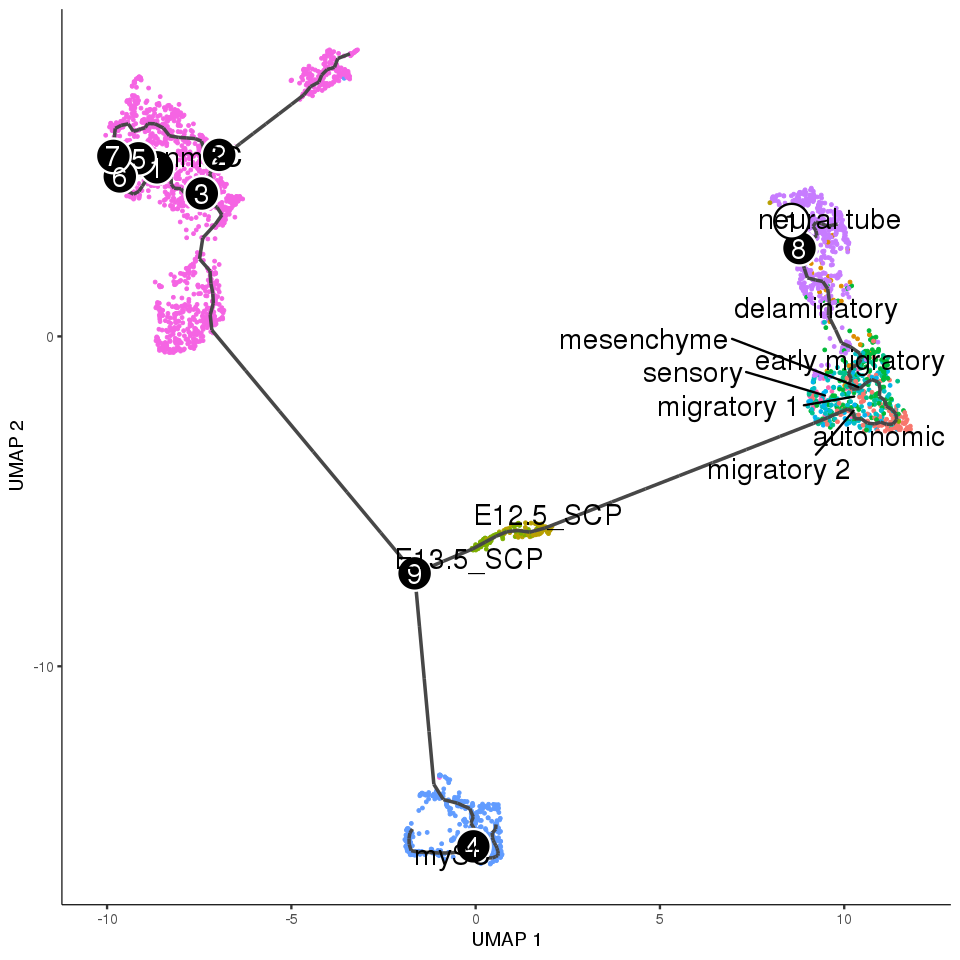

In [15]:
options(repr.plot.width=8,repr.plot.height=8)

#Note that the trajectory will change slightly depending on the random number seed used for the resampling process.
#However, the overall topology typically remains consistent.
plot_cells(trajectory_cds_obj,
           color_cells_by = "cell.type",
           label_groups_by_cluster=F,
           label_leaves=F,cell_size=0.6,
           label_branch_points=T,
           graph_label_size=6,group_label_size=6)

# Score Schwann cells in PNF using development markers

In [53]:
marker_gene_list <- create_unique_marker_lists( markers_df, num_markers=100 )
mouse_pnf_obj <- load_pnf_scs()

Boiler-plate AUCell code below.

We score PNF cells according to the markers derived from running `FindAllMarkers` on the `development_obj`
Seurat object.

AUCell outputs gene set activity values between 0 and 1, where a higher value implies higher gene set activity. We use the top 100 marker genes here, since the top 300 marker genes (which is the number used for bulk analyses) tend to
poorly discriminate between nmSC and mySC in the single-cell data.

Quantiles for the number of genes detected by cell: 
(Non-detected genes are shuffled at the end of the ranking. Keep it in mind when choosing the threshold for calculating the AUC).



    min      1%      5%     10%     50%    100% 
2067.00 2119.28 2219.80 2286.20 3029.00 5780.00 


Using 6 cores.

Genes in the gene sets NOT available in the dataset: 
	mySC: 	1 (2% of 54)
	neural tube: 	1 (2% of 61)
	migratory 1: 	3 (4% of 69)
	migratory 2: 	1 (6% of 18)
	delaminatory: 	2 (3% of 61)
	early migratory: 	1 (1% of 71)
	E12.5_SCP: 	10 (14% of 70)
	E13.5_SCP: 	6 (8% of 74)



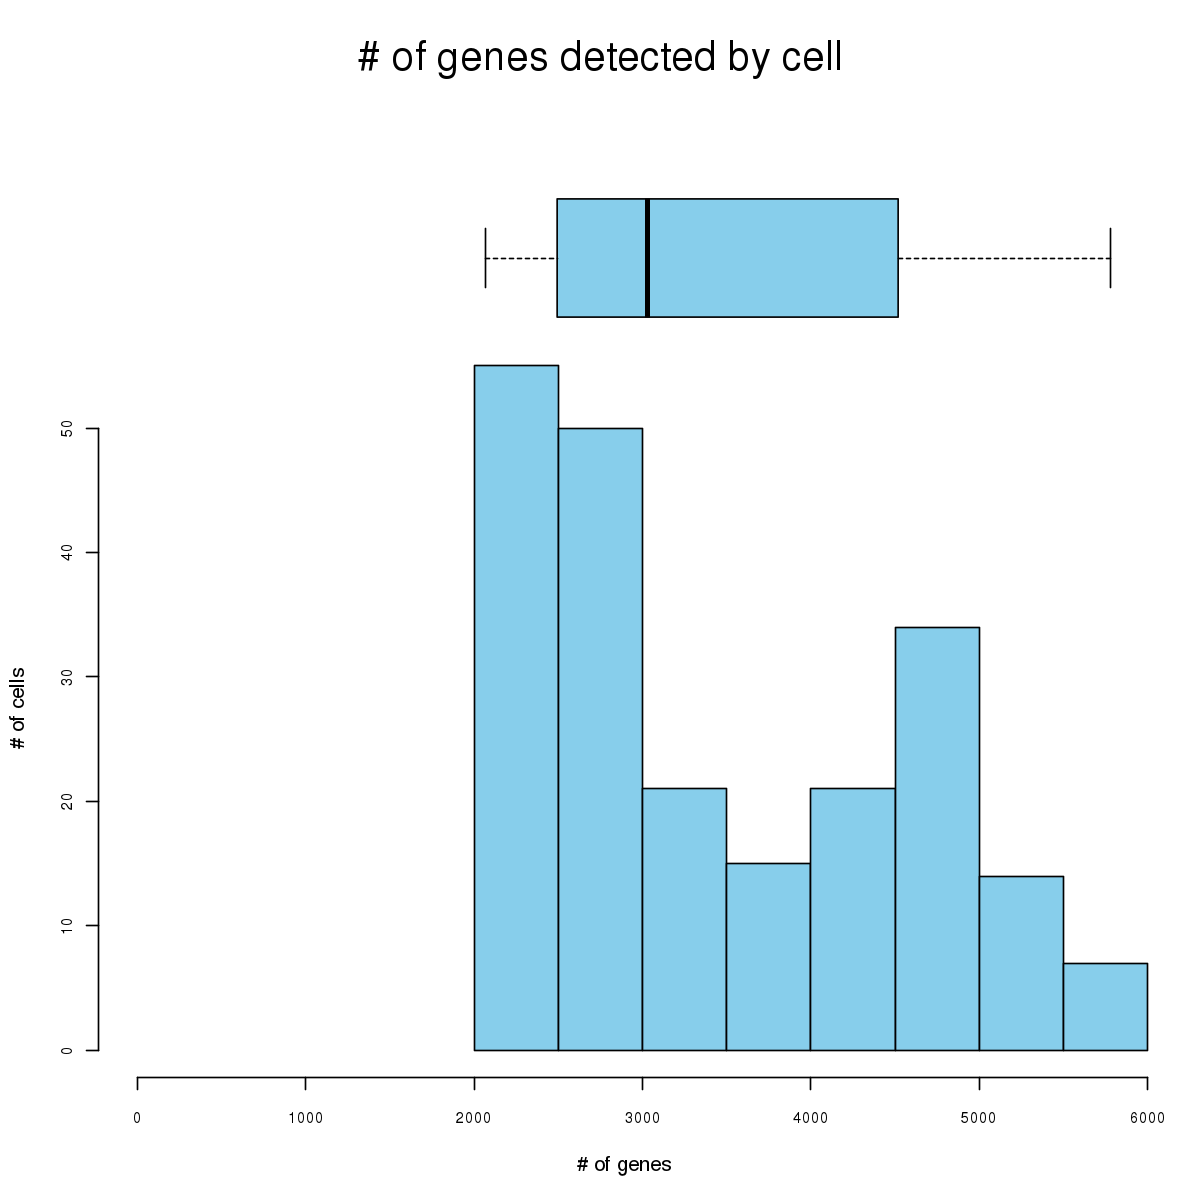

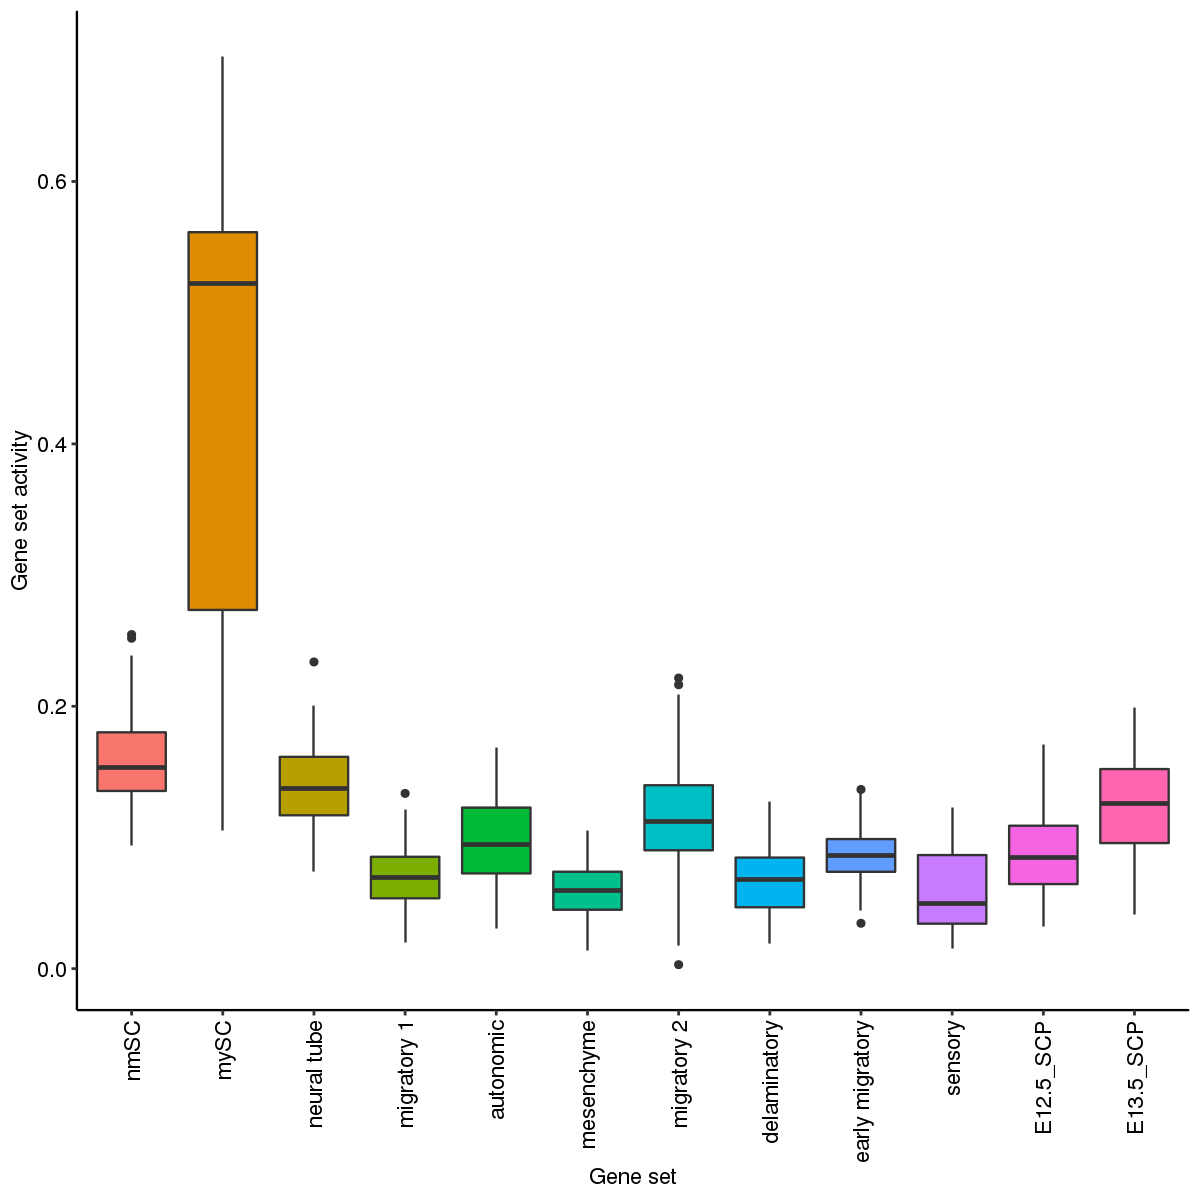

In [54]:
rankings <- AUCell_buildRankings( mouse_pnf_obj[["RNA"]]@counts, nCores=6 )
auc_obj <- AUCell_calcAUC( marker_gene_list, rankings)
aucell_df <- reshape2::melt( getAUC(auc_obj) )
ggplot( aucell_df ) + geom_boxplot(aes(x=`gene sets`,y=value,fill=`gene sets`)) + theme_pubr(base_size=13) +
theme(axis.text.x=element_text(angle=90,vjust=0.5,hjust=1),legend.position="none") + 
ylab("Gene set activity") + xlab("Gene set")

# Publicly available MPNST tumor data

In [56]:
#We picked 300 marker genes here to produce the heatmaps shown elsewhere. The results are 
#pretty identical with 100 marker genes too. 
bulk_marker_gene_list <- create_unique_marker_lists( markers_df, num_markers=300 )
merged_mpnst_dt <- load_human_mpnst_data()

In [ ]:
human_marker_gene_list <- list()

#Since the markers are derived are from mice, we need to find human orthologs of each marker gene.
for (cell_type in names(marker_gene_list)) {
    print(cell_type)
    flush.console()
    human_marker_gene_list[[cell_type]] <- get_orthologs( bulk_marker_gene_list[[cell_type]], from_species = "mouse",
                                                        to_species = "human") %>% pull(human_gene_name)
}

In [59]:
developing_cell_types <- names(marker_gene_list)
mpnst_samples <- setdiff(colnames(merged_mpnst_dt),"Symbol")
signature_score_mat <- matrix(0,nrow=length(developing_cell_types),ncol=length(mpnst_samples),
                             dimnames=list(developing_cell_types,mpnst_samples))
gene_exp_mat <- as.matrix(tibble::column_to_rownames(merged_mpnst_dt,"Symbol"))


#Each signature is evaluated by computing the mean expression of all the genes
#in the signature in each sample
for (cell_type in developing_cell_types) {
    genes <- human_marker_gene_list[[cell_type]]
    
    #Not all marker genes may be amongst the list of expressed genes in the data being analyzed.
    markers_present <- genes[genes %in% rownames(gene_exp_mat)]
    
    signature_score_mat[cell_type,] <- colMeans(gene_exp_mat[markers_present,])
}

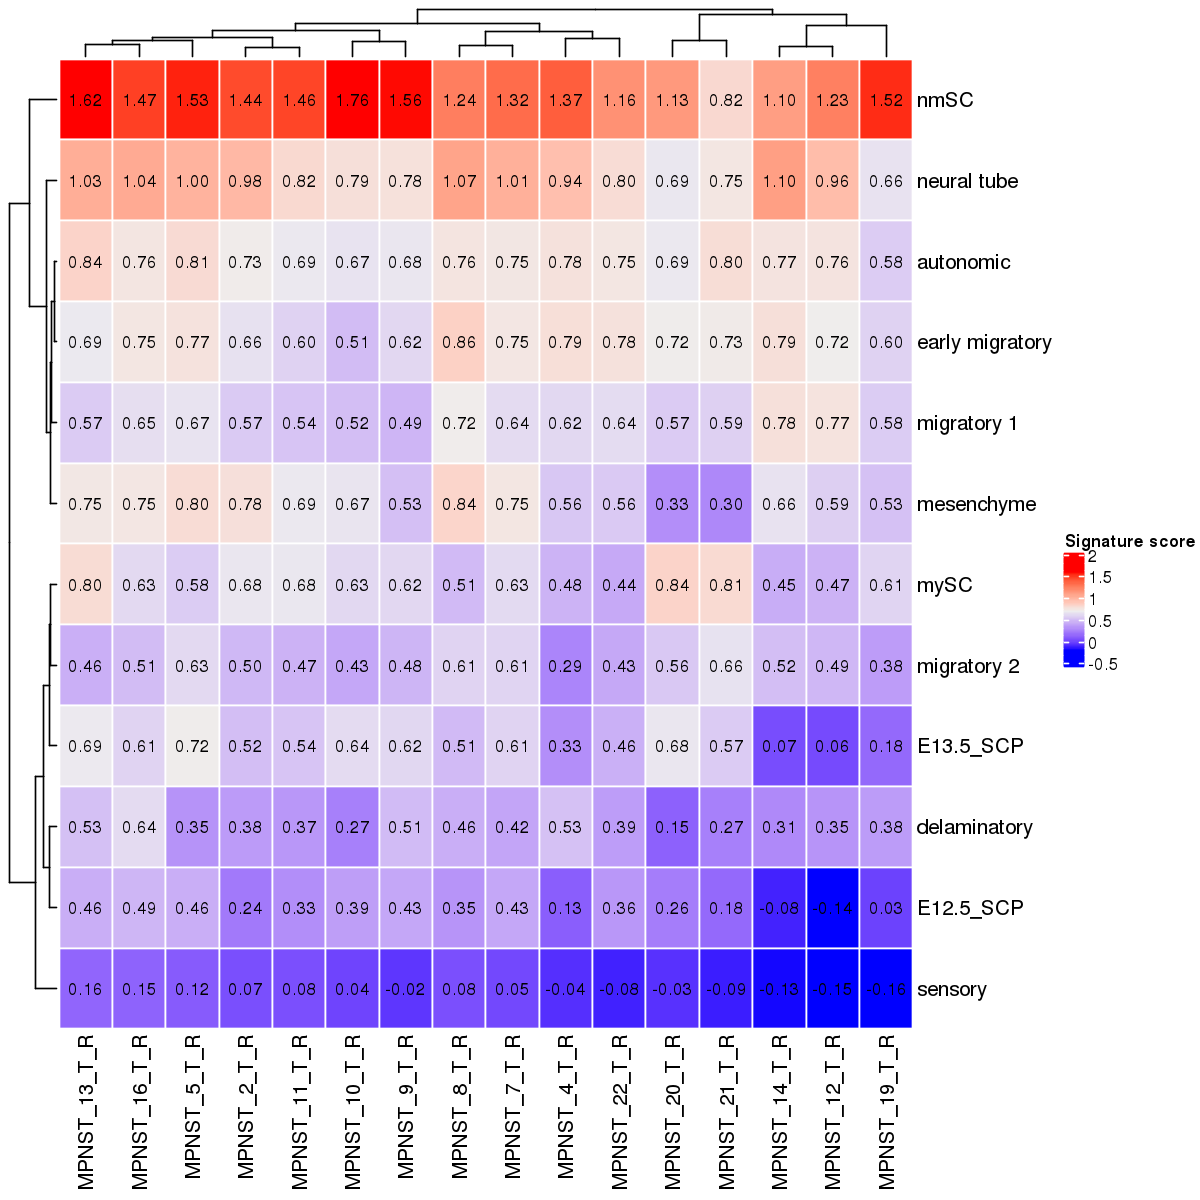

In [60]:
options(repr.plot.width=10,repr.plot.height=10)
p_signature_heatmap <- Heatmap( signature_score_mat,
                               rect_gp = gpar(col = "white", lwd = 1),
        name="Signature score", cell_fun= function(j, i, x, y, width, height, fill) {
  grid.text(sprintf("%.2f", signature_score_mat[i, j]), x, y, gp = gpar(fontsize = 10)) }) 
p_signature_heatmap
